In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [24]:
# 1. Read the Temperature CSV file into a DataFrame
df = pd.read_csv("temperature_nsw.csv")

# 2. Convert the 'DATETIME' column in TEMP dataset to datetime format
df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%d/%m/%Y %H:%M')


# 3. Extract the hour and minute from the 'datetime' column
df['HOUR'] = df['DATETIME'].dt.hour
df['MINUTE'] = df['DATETIME'].dt.minute

# 4. Remove rows where 'MINUTE' is not 0 or 30
df = df[df['MINUTE'].isin([0, 30])]

# 5. Read the energy demand CSV file into a DataFrame
df_energy = pd.read_csv('totaldemand_nsw.csv')

# 6. Convert the 'DATETIME' column to datetime format for the energy dataset
df_energy['DATETIME'] = pd.to_datetime(df_energy['DATETIME'],  format='%d/%m/%Y %H:%M')

# 7. Merge the two DataFrames on 'DATETIME'
df_merged = pd.merge(df, df_energy, on='DATETIME', how='inner')

# 8. Extract the day, month, and year from the 'datetime' column and add as variables
df_merged['DAY'] = df_merged['DATETIME'].dt.day
df_merged['MONTH'] = df_merged['DATETIME'].dt.month
df_merged['YEAR'] = df_merged['DATETIME'].dt.year

# 9. Update the name of the df to ShortTerm, use copy method so that we can manipulate df_merged for the medium-term modelling dataset
df_ShortTerm = df_merged.copy()

# 10. Add a new field called 'count' and populate each row with 1
df_ShortTerm['count'] = 1

# 11. Group by the 'DAY', 'MONTH', 'YEAR', and 'HOUR' fields
grouped_df = df_ShortTerm.groupby(['DAY', 'MONTH', 'YEAR','HOUR']).agg({
    'TEMPERATURE': 'mean',  # Average the 'temp' field
    'TOTALDEMAND': 'sum',  # Sum the 'energy_demand' field
    'count': 'sum'  # Sum the 'count' field
}).reset_index()

# 12. Remove any rows where both the hourly and 1/2hourly is unavailable. Ie Drop all rows where 'count' is less than 2
df_ShortTerm = grouped_df[grouped_df['count'] >= 2]

# 13. drop the COUNT field
df_ShortTerm = df_ShortTerm.drop(['count'], axis=1)

# 14. rebuild date field
df_ShortTerm['DATE'] = pd.to_datetime(dict(year=df_ShortTerm['YEAR'], month=df_ShortTerm['MONTH'], day=df_ShortTerm['DAY']))

# 15. Add weekday number and week number to the variables then drop date (redundant field)
df_ShortTerm['WEEKDAY_Num'] = df_ShortTerm['DATE'].dt.weekday + 1  # Monday=1, Sunday=7
df_ShortTerm['WEEK_Num'] = df_ShortTerm['DATE'].dt.isocalendar().week
df_ShortTerm = df_ShortTerm.drop(['DATE'], axis=1)

In [3]:
df_merged.head()

,LOCATION,DATETIME,TEMPERATURE,HOUR,MINUTE,TOTALDEMAND,REGIONID,DAY,MONTH,YEAR
0,Bankstown,2010-01-01 00:00:00,23.1,0,0,8038.00,NSW1,1,1,2010
1,Bankstown,2010-01-01 00:30:00,22.9,0,30,7809.31,NSW1,1,1,2010
2,Bankstown,2010-01-01 01:00:00,22.6,1,0,7483.69,NSW1,1,1,2010
3,Bankstown,2010-01-01 01:30:00,22.5,1,30,7117.23,NSW1,1,1,2010
4,Bankstown,2010-01-01 02:00:00,22.5,2,0,6812.03,NSW1,1,1,2010


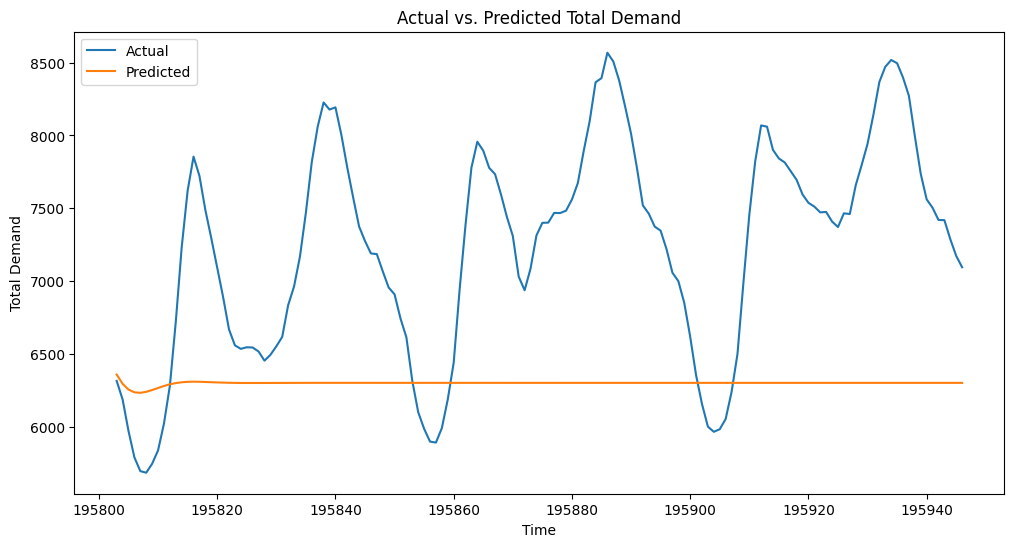

MAPE: 13.478745708649623
MSE: 1413914.8964912437
RMSE: 1189.0815348373903
MAE: 1023.9736443622215
R-squared: -1.5960491063218076


In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


X = df_merged['TEMPERATURE']
y = df_merged['TOTALDEMAND']


train_size = len(df_merged) - 3 * 48   #(30 minutes interval)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


model = ARIMA(y_train, order=(5,1,0))  # ARIMA(5,1,0) 
model_fit = model.fit()

predictions = model_fit.forecast(steps=3*48)  

# Calculate evaluation metrics
def evaluate_forecast(true, pred):
    mape = np.mean(np.abs((true - pred) / true)) * 100
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    return mape, mse, rmse, mae, r2

mape, mse, rmse, mae, r2 = evaluate_forecast(y_test, predictions)


plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Total Demand')
plt.title('Actual vs. Predicted Total Demand')
plt.legend()
plt.show()


print("MAPE:", mape)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


df_merged['DATETIME'] = pd.to_datetime(df_merged['DATETIME'])
df_merged.set_index('DATETIME', inplace=True)


df = df_merged[['TEMPERATURE', 'TOTALDEMAND']]


train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Define SARIMA model
order = (5, 1, 0) 
seasonal_order = (1, 1, 1, 24) 
model = SARIMAX(train['TOTALDEMAND'], order=order, seasonal_order=seasonal_order)

# Fit SARIMA model
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluate the model
mape = np.mean(np.abs(test['TOTALDEMAND'] - forecast) / test['TOTALDEMAND']) * 100
mse = mean_squared_error(test['TOTALDEMAND'], forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['TOTALDEMAND'], forecast)
r2 = r2_score(test['TOTALDEMAND'], forecast)

print("MAPE: ", mape)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)


plt.figure(figsize=(12, 6))
plt.plot(test.index, test['TOTALDEMAND'], label='Actual')
plt.plot(test.index, forecast, color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('SARIMA Forecast vs Actual')
plt.legend()
plt.show()


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.25183D+00    |proj g|=  4.69624D-02


 This problem is unconstrained.



At iterate    5    f=  6.23419D+00    |proj g|=  2.35892D-02

At iterate   10    f=  6.22994D+00    |proj g|=  2.12876D-02

At iterate   15    f=  6.21987D+00    |proj g|=  5.94725D-03

At iterate   20    f=  6.12523D+00    |proj g|=  1.16890D-01

At iterate   25    f=  5.95488D+00    |proj g|=  9.59514D-02

At iterate   30    f=  5.90078D+00    |proj g|=  8.95658D-03

At iterate   35    f=  5.90044D+00    |proj g|=  2.87560D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     49      1     0     0   2.985D-06   5.900D+00
  F =   5.9004418162553121     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df_merged['DATETIME'] = pd.to_datetime(df_merged['DATETIME'])
df_merged.set_index('DATETIME', inplace=True)
df = df_merged[['TEMPERATURE', 'TOTALDEMAND']]


train, test = df.iloc[:int(len(df) * 0.8)], df.iloc[int(len(df) * 0.8):]


model = SARIMAX(train['TOTALDEMAND'], exog=train['TEMPERATURE'], order=(5, 1, 0), seasonal_order=(1, 1, 1, 24))


model_fit = model.fit()


forecast = model_fit.forecast(steps=len(test), exog=test['TEMPERATURE'])


mape = np.mean(np.abs(test['TOTALDEMAND'] - forecast) / test['TOTALDEMAND']) * 100
mse = mean_squared_error(test['TOTALDEMAND'], forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['TOTALDEMAND'], forecast)
r2 = r2_score(test['TOTALDEMAND'], forecast)

print("MAPE: ", mape)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)

# Plot the results
plt.plot(test.index, test['TOTALDEMAND'], label='Actual')
plt.plot(test.index, forecast, color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('SARIMA Forecast vs Actual')
plt.legend()
plt.show()


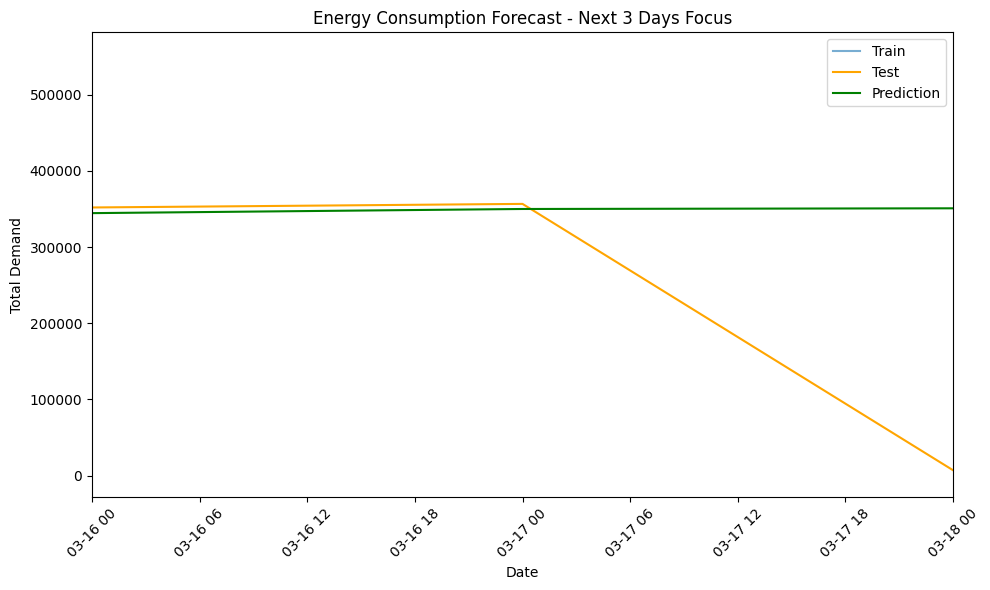

MAPE: 1616.0451544684595
MSE: 39402673796.928505
RMSE: 198501.06749569008
MAE: 119259.71757075046
R-squared: -0.4714376152786539


In [11]:
#FINAL MODEL FOR SAMIRAX 3 DAYS FOCUS SCOPE

import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt


df_daily = df_merged.set_index('DATETIME').resample('D').agg({'TEMPERATURE':'mean', 'TOTALDEMAND':'sum'})

# Handling missing or infinite values
df_daily['TEMPERATURE'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_daily['TEMPERATURE'].fillna(method='ffill', inplace=True)  # Forward fill
df_daily['TOTALDEMAND'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_daily['TOTALDEMAND'].fillna(method='ffill', inplace=True)  # Forward fill


assert not df_daily.isnull().any().any(), "There are still NaNs in the dataframe."


train = df_daily.iloc[:-3, :]
test = df_daily.iloc[-3:, :]


model = SARIMAX(train['TOTALDEMAND'], 
                exog=train['TEMPERATURE'],
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 7))


model_fit = model.fit(disp=False)


end = len(train) + len(test) - 1
prediction = model_fit.predict(start=len(train), end=end, exog=test['TEMPERATURE'])

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['TOTALDEMAND'], label='Train', alpha=0.6) 
plt.plot(test.index, test['TOTALDEMAND'], label='Test', color='orange')
plt.plot(prediction.index, prediction, label='Prediction', color='green')


plt.xlim([test.index[0], test.index[-1]])

plt.legend()
plt.title('Energy Consumption Forecast - Next 3 Days Focus')
plt.xlabel('Date')
plt.ylabel('Total Demand')
plt.xticks(rotation=45) 
plt.tight_layout()  
plt.show()


mape = np.mean(np.abs(prediction - test['TOTALDEMAND']) / test['TOTALDEMAND']) * 100
mse = mean_squared_error(test['TOTALDEMAND'], prediction)
rmse = sqrt(mse)
mae = mean_absolute_error(test['TOTALDEMAND'], prediction)
r_squared = r2_score(test['TOTALDEMAND'], prediction)

print(f"MAPE: {mape}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r_squared}")


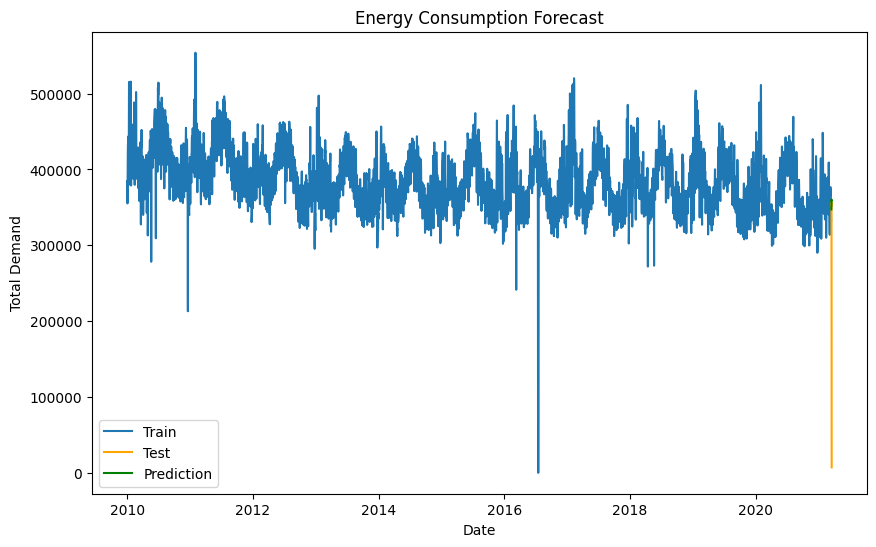

MAPE: 1655.6048230551387
MSE: 41360873361.591705
RMSE: 203373.72829741728
MAE: 120191.41737167827
R-squared: -0.5445638328677842


In [10]:
#FINAL SAMIRA MODEL WIDE SCOPE

import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
import warnings


df_merged['DATETIME'] = pd.to_datetime(df_merged['DATETIME'])


df_daily = df_merged.set_index('DATETIME').resample('D').agg({'TEMPERATURE':'mean', 'TOTALDEMAND':'sum'})


df_daily['TEMPERATURE'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_daily['TEMPERATURE'].fillna(method='ffill', inplace=True)  
df_daily['TOTALDEMAND'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_daily['TOTALDEMAND'].fillna(method='ffill', inplace=True) 


assert not df_daily.isnull().any().any(), "There are still NaNs in the dataframe."


train = df_daily.iloc[:-3, :]
test = df_daily.iloc[-3:, :]


model = SARIMAX(train['TOTALDEMAND'], 
                exog=train['TEMPERATURE'],
                order=(1, 0, 2),  # (p, d, q)
                seasonal_order=(1, 1, 2, 7))  # (P, D, Q, s)

model_fit = model.fit(disp=False)


end = len(train) + len(test) - 1
prediction = model_fit.predict(start=len(train), end=end, exog=test['TEMPERATURE'])

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['TOTALDEMAND'], label='Train')
plt.plot(test.index, test['TOTALDEMAND'], label='Test', color='orange')
plt.plot(prediction.index, prediction, label='Prediction', color='green')
plt.legend()
plt.title('Energy Consumption Forecast')
plt.xlabel('Date')
plt.ylabel('Total Demand')
plt.show()

mape = np.mean(np.abs(prediction - test['TOTALDEMAND']) / test['TOTALDEMAND']) * 100
mse = mean_squared_error(test['TOTALDEMAND'], prediction)
rmse = sqrt(mse)
mae = mean_absolute_error(test['TOTALDEMAND'], prediction)
r_squared = r2_score(test['TOTALDEMAND'], prediction)

print(f"MAPE: {mape}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r_squared}")


MAPE: 0.13958259943277415
MSE: 2492529.273909724
RMSE: 1578.7746114977033
MAE: 1192.4885907610005
R Squared: -0.5876845408229199


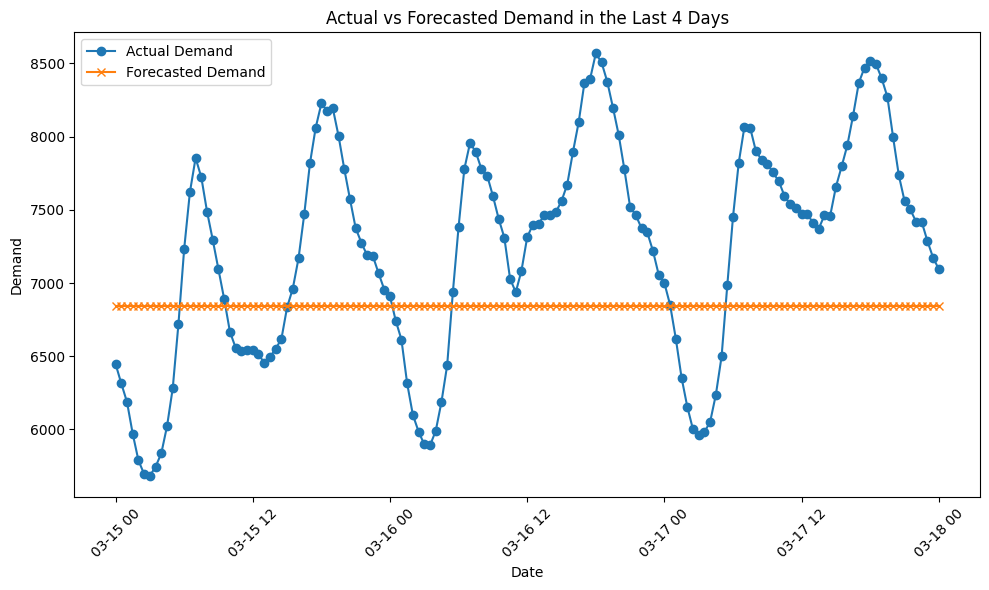

In [19]:
#ARIMA 3 DAY PREDICT 

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt




df_merged.set_index('DATETIME', inplace=True)


y = df_merged['TOTALDEMAND']


train_size = int(len(y) * 0.8)
train, test = y[0:train_size], y[train_size:len(y)]


model = ARIMA(train, order=(5,1,0))  
model_fit = model.fit()


forecast = model_fit.forecast(steps=len(test))


mape = mean_absolute_percentage_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = sqrt(mse)
mae = mean_absolute_error(test, forecast)
r_squared = r2_score(test, forecast)

print(f"MAPE: {mape}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R Squared: {r_squared}")

test.index = pd.to_datetime(test.index)

last_4_days = test.index.max() - pd.Timedelta(days=3)
test_filtered = test[test.index >= last_4_days]
forecast_filtered = forecast[test.index >= last_4_days]

plt.figure(figsize=(10, 6))
plt.plot(test_filtered.index, test_filtered, label='Actual Demand', marker='o')
plt.plot(test_filtered.index, forecast_filtered, label='Forecasted Demand', marker='x')
plt.title('Actual vs Forecasted Demand in the Last 4 Days')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


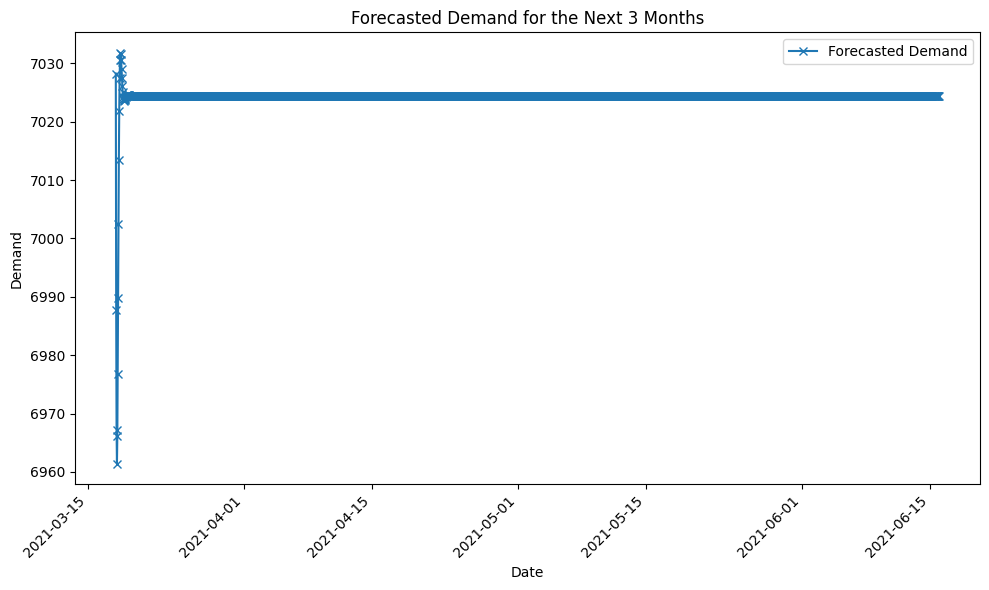

In [25]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

df_merged.set_index('DATETIME', inplace=True)

y = df_merged['TOTALDEMAND']

train = y

model = ARIMA(train, order=(5,1,0)) 
model_fit = model.fit()

forecast_steps = 30 * 24 * 3 
forecast = model_fit.forecast(steps=forecast_steps)

last_date = train.index[-1]
future_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='H')[1:]  

plt.figure(figsize=(10, 6))
plt.plot(future_dates, forecast, label='Forecasted Demand', marker='x')
plt.title('Forecasted Demand for the Next 3 Months')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
df_merged.dtypes

LOCATION               object
DATETIME       datetime64[ns]
TEMPERATURE           float64
HOUR                    int32
MINUTE                  int32
TOTALDEMAND           float64
REGIONID               object
DAY                     int32
MONTH                   int32
YEAR                    int32
dtype: object

In [32]:


df_energy = df_merged[['DATETIME', 'TOTALDEMAND']]

df_energy.set_index('DATETIME', inplace=True)

df_energy = df_energy.resample('H').mean().fillna(method='ffill')

train_size = int(len(df_energy) * 0.8)
train, test = df_energy.iloc[:train_size], df_energy.iloc[train_size:]

model = ARIMA(train, order=(3,1,0))
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test))

stderr = model_fit.get_forecast(steps=len(test)).se_mean
conf_int = model_fit.get_forecast(steps=len(test)).conf_int()

mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print('Test RMSE: %.3f' % rmse)


Test RMSE: 1483.342


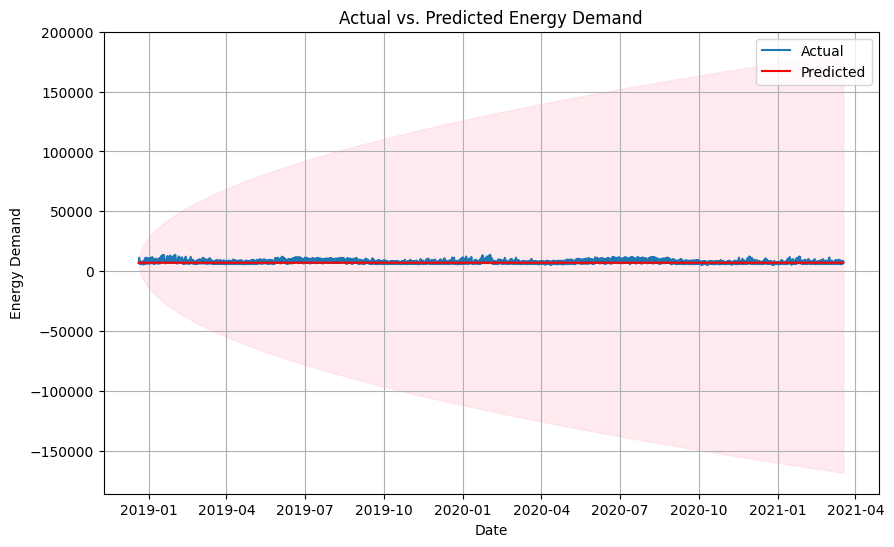

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, forecast, color='red', label='Predicted')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Actual vs. Predicted Energy Demand')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()
plt.grid(True)
plt.savefig('test.png')
plt.show()




Test RMSE: 407.240


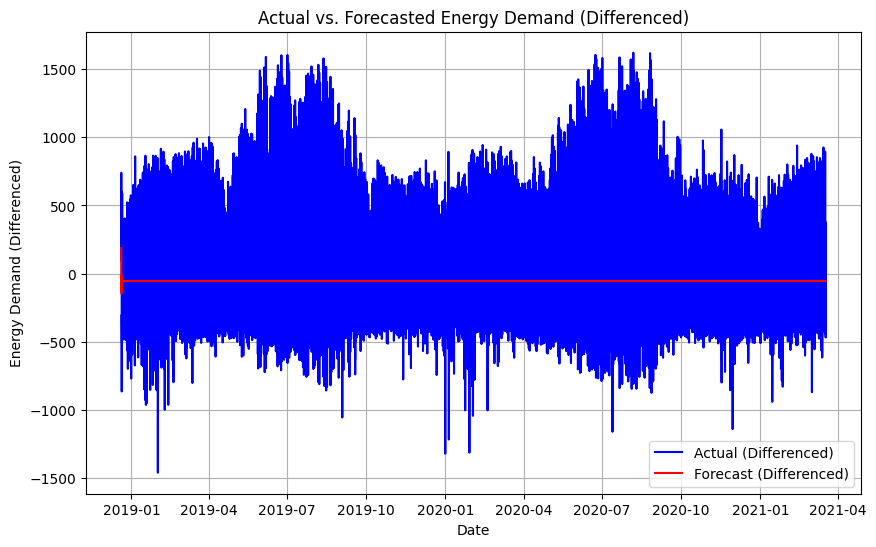

In [46]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df_energy_transformed = df_energy.copy()

df_energy_transformed['TOTALDEMAND_diff'] = df_energy_transformed['TOTALDEMAND'].diff()

df_energy_transformed = df_energy_transformed.dropna()

train_size = int(len(df_energy_transformed) * 0.8)
train, test = df_energy_transformed.iloc[:train_size], df_energy_transformed.iloc[train_size:]

model = ARIMA(train['TOTALDEMAND_diff'], order=(6,1,0))
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test))

stderr = model_fit.get_forecast(steps=len(test)).se_mean
conf_int = model_fit.get_forecast(steps=len(test)).conf_int()

mse = mean_squared_error(test['TOTALDEMAND_diff'], forecast)
rmse = np.sqrt(mse)
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['TOTALDEMAND_diff'], label='Actual (Differenced)', color='blue')
plt.plot(test.index, forecast, label='Forecast (Differenced)', color='red')

plt.title('Actual vs. Forecasted Energy Demand (Differenced)')
plt.xlabel('Date')
plt.ylabel('Energy Demand (Differenced)')
plt.legend()
plt.grid(True)
plt.show()


Forecasted demand for the next month:
2018-12-20 05:00:00    7281.952449
2018-12-20 06:00:00    7372.260693
2018-12-20 07:00:00    7353.367850
2018-12-20 08:00:00    7248.934319
2018-12-20 09:00:00    7104.337654
2018-12-20 10:00:00    6969.702460
2018-12-20 11:00:00    6881.340216
2018-12-20 12:00:00    6840.425492
2018-12-20 13:00:00    6823.417298
2018-12-20 14:00:00    6804.977879
2018-12-20 15:00:00    6769.585521
2018-12-20 16:00:00    6714.365055
2018-12-20 17:00:00    6646.016810
2018-12-20 18:00:00    6574.998108
2018-12-20 19:00:00    6509.677496
2018-12-20 20:00:00    6453.007827
2018-12-20 21:00:00    6402.978730
2018-12-20 22:00:00    6355.259438
2018-12-20 23:00:00    6305.938563
2018-12-21 00:00:00    6253.131909
2018-12-21 01:00:00    6197.150939
2018-12-21 02:00:00    6139.641360
2018-12-21 03:00:00    6082.396691
2018-12-21 04:00:00    6026.491924
2018-12-21 05:00:00    5972.035575
2018-12-21 06:00:00    5918.444379
2018-12-21 07:00:00    5864.938448
2018-12-21 08:00:

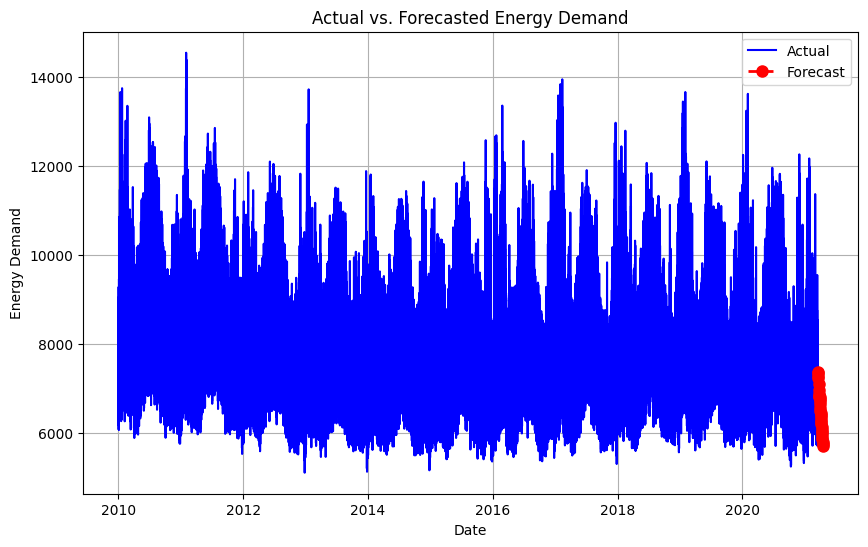

In [49]:

forecast_next_month_diff = model_fit.forecast(steps=30)  

forecast_next_month = forecast_next_month_diff.cumsum() + df_energy['TOTALDEMAND'].iloc[-1] 

print("Forecasted demand for the next month:")
print(forecast_next_month)

next_month_dates = pd.date_range(start=df_energy.index[-1], periods=30, freq='D')

plt.figure(figsize=(10, 6))
plt.plot(df_energy.index, df_energy['TOTALDEMAND'], label='Actual', color='blue')
plt.plot(next_month_dates, forecast_next_month, label='Forecast', color='red', linestyle='--', linewidth=2, marker='o', markersize=8)
plt.title('Actual vs. Forecasted Energy Demand')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()
plt.grid(True)
plt.show()


